# Backtesting and Crossover moving averages strategy

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
import pandas_datareader as pdr

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (16,10)
plt.rcParams['figure.autolayout'] = True
plt.rcParams['axes.grid'] = True

In [2]:
def getData(index,start_date,end_date):
    return pdr.DataReader(index,"yahoo",start_date,end_date)

## Crossover moving averages strategy

In [3]:
class MovingAverageStrategy(object):
    
    def __init__(self, index, data, short_window=100, long_window=400):
        self.index = index
        self.data = data
        self.short_window = short_window
        self.long_window = long_window
        self.signals = self.generate_signals()

    def generate_signals(self):
        signals = pd.DataFrame(index=self.data.index)
        signals['signal'] = 0.0
        
        rolling_short = self.data['Close'].rolling(self.short_window, min_periods=1)
        rolling_long = self.data['Close'].rolling(self.long_window, min_periods=1)
        signals['short_mavg'] = rolling_short.mean()
        signals['long_mavg'] = rolling_long.mean()

        signals['signal'][self.short_window:] = np.where(signals['short_mavg'][self.short_window:] > signals['long_mavg'][self.short_window:], 1.0, 0.0)   

        signals['positions'] = signals['signal'].diff()
        signals['positions'].fillna(0,inplace=True)
        
        return signals
    
    def plot_signals(self):
        plt.plot(self.data['Close'],lw=3,label='real_price',alpha=0.8)
        plt.plot(self.signals['short_mavg'],lw=2,ls='--',label='short_mavg')
        plt.plot(self.signals['long_mavg'],lw=2,label='long_mavg')
        plt.plot(self.signals.loc[self.signals.positions == 1.0].index, self.signals.short_mavg[self.signals.positions == 1.0],'^', markersize=15, color='g',label='buy',alpha=0.8)
        plt.plot(self.signals.loc[self.signals.positions == -1.0].index, self.signals.short_mavg[self.signals.positions == -1.0],'v', markersize=15, color='r',label='sell',alpha=0.8)
        plt.legend(fontsize='large')
        plt.xlabel('Date')
        plt.ylabel('Price of '+str(self.index)+ ' in $')
        plt.title("Moving average on "+ self.index+'\n'+' short_window: '+str(self.short_window)+' long window: '+str(self.long_window))

#### Class MovingAverageStrategy as the name suggest creates signals for buying and selling shares on two moving average crossovers. Initializations parameters are: 

    - index - on which we trade(ex. AAPL,...)
    - data - data set on which we create signals
    - short_window - loockback period to calculete short rolling mean
    - long_window - loockback period to calculate long rolling mean

#### Class has two methods:

    - generate_signals - we generate signals of buying and selling stocks with two rolling means
    - plot_signals

#### In next couple of lines we see youse of this class:

In [93]:
index = 'SPY'
data = getData(index,"1993-01-28","2000-01-01")
short = 10 #two months short moving average window
long = 50 #one year long moving average window

In [94]:
mavg = MovingAverageStrategy(index,data,short,long)

In [95]:
signals = mavg.generate_signals()

In [7]:
signals.head(2)

,signal,short_mavg,long_mavg,positions
Date,,,,
1993-01-29,0.0,43.93750,43.93750,0.0
1993-02-01,0.0,44.09375,44.09375,0.0


In [8]:
signals[signals['signal']==1].head(2)

,signal,short_mavg,long_mavg,positions
Date,,,,
1993-02-12,1.0,44.725000,44.653409,1.0
1993-02-16,1.0,44.646875,44.554688,0.0


In [9]:
signals['1993-02-17':'1993-02-21']

,signal,short_mavg,long_mavg,positions
Date,,,,
1993-02-17,1.0,44.556250,44.468750,0.0
1993-02-18,1.0,44.415625,44.392857,0.0
1993-02-19,0.0,44.271875,44.337500,-1.0


#### From above tables we can see how we generate signals table. When *short_mavg* is greather then *long_mavg* then *signal=1* else *signal=0*, column *positions* give us time when to buy shares (equals 1), end time when to sell shares (equals -1) Let's plot that:

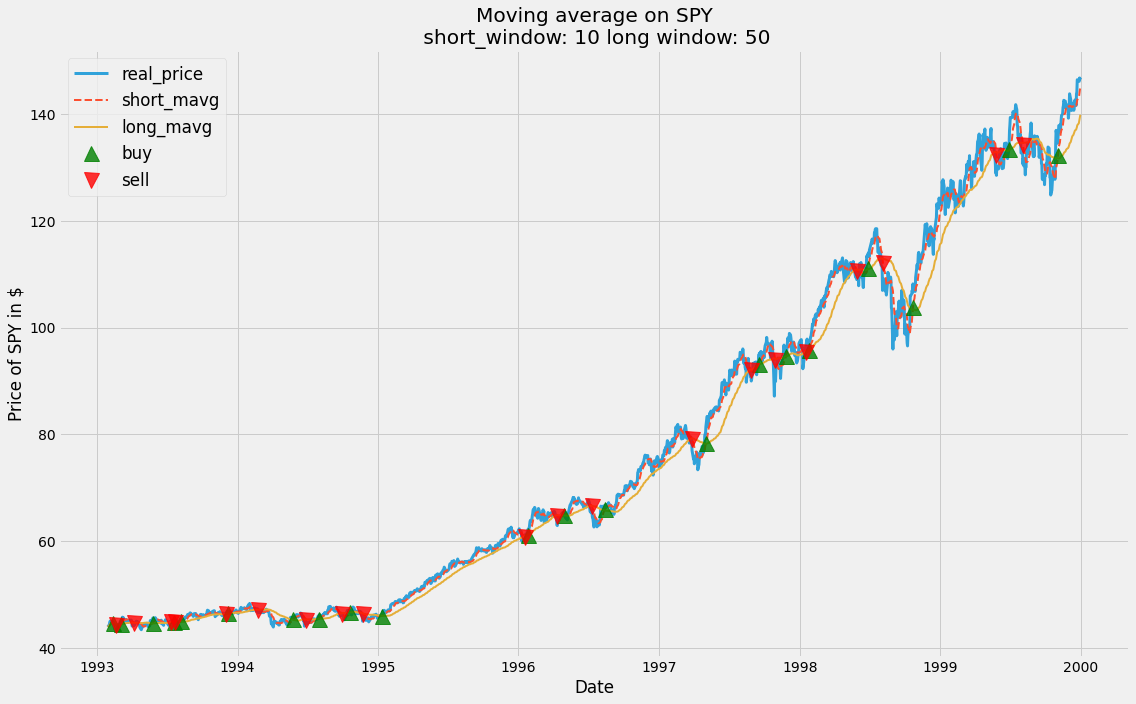

In [10]:
mavg.plot_signals()

## Backtesting portfolio

In [61]:
class BacktestPortfolio(object):

    def __init__(self, index, data, signals, initial_capital=100000.0, trade_costs=0.0025, number_of_shares =100,):
        self.index = index        
        self.data = data
        self.signals = signals
        self.initial_capital = float(initial_capital)
        self.trade_costs = float(trade_costs)
        self.number_of_shares = number_of_shares
        self.positions = self.generate_positions()
        self.portfolio = self.backtest_portfolio()
        
    def generate_positions(self):
        positions = pd.DataFrame(index=self.signals.index).fillna(0.0)
        positions[self.index] = self.number_of_shares*self.signals['signal']
        return positions
                    
    def backtest_portfolio(self):
        portfolio = pd.DataFrame(index=self.signals.index).fillna(0.0)
        portfolio['cash']=self.initial_capital
        pos_diff = self.positions[self.index].diff()
        pos_diff.fillna(0.0)
        
        portfolio['numberOfStocks'] = self.positions[self.index]
        portfolio['holdingInStock'] = self.positions[self.index]*self.data['Close']
        portfolio['cash'] = portfolio['cash'] - (pos_diff*data['Close'].shift(1)+self.trade_costs*pos_diff.abs()*data['Close'].shift(1)).cumsum()
        
        portfolio['total'] = portfolio['cash'] + portfolio['holdingInStock']
        portfolio['returns'] = portfolio['total'].pct_change()

        return portfolio
    
    
    def plot_equity(self,signal=True):
        plt.plot(self.portfolio['total'],lw=2,alpha=0.8)
        plt.axhline(y=self.portfolio['cash'].min(),color='red',label='min(cash)='+str(round(self.portfolio['cash'].min())))
        if signal:
            plt.plot(self.portfolio.loc[signals.positions == 1.0].index, self.portfolio.total[signals.positions == 1.0],'^', markersize=15, color='g',label='buy',alpha=0.8)
            plt.plot(self.portfolio.loc[signals.positions == -1.0].index, self.portfolio.total[signals.positions == -1.0],'v', markersize=15, color='r',label='sell',alpha=0.8)
        plt.legend(fontsize='large')
        plt.xlabel('Date')
        plt.ylabel('Portfolio value in $')
        plt.title("Equity curve in $"+"\n"+"number of shares: "+str(self.number_of_shares))

Class BacktestPortfolio as the name suggest plots the equity curve of invested money 
and generates positions and using that method creates portfolio table (basing on strategy signals).
It has initialisations parameters:
    
    - index (on which we trade(ex. AAPL,...)
    - data (data set on which we create portfolio)
    - signals (strategy signals, signals of buying and selling shares)
    - initial_capital - money for investing
    - trade cost
    - number_of shares - in next few lines we will tell more about this

Backtesting is implemented that we always buys and sell same amount of shares, initial 100 of shares.
Maybe, we can explore something like this: to buy in every buy signal more and more shares, and to sell all or to sell less number of shares then we buy, it is going to be implemented via *generate_positions2* method.

Also, when we calculate buying price of shares we are taking the closing price of the day before.

Lest's see how backtesting looks on our values and signals generated above:

In [74]:
index = 'SPY'
data = getData(index,"1993-01-28","2000-01-01")
short = 10 #two months short moving average window
long = 50 #one year long moving average window

In [13]:
mavg = MovingAverageStrategy(index,data,short,long)
signals = mavg.generate_signals()

In [14]:
portfolio = BacktestPortfolio(index, data, signals, initial_capital=100000.0, trade_costs=0.0025, number_of_shares = 150)
result = portfolio.backtest_portfolio()

In [15]:
result.head(5)

,cash,numberOfStocks,holdingInStock,total,returns
Date,,,,,
1993-01-29,NaN,0.0,0.0,NaN,NaN
1993-02-01,100000.0,0.0,0.0,100000.0,NaN
1993-02-02,100000.0,0.0,0.0,100000.0,0.0
1993-02-03,100000.0,0.0,0.0,100000.0,0.0
1993-02-04,100000.0,0.0,0.0,100000.0,0.0


Let's see how portfolio table look in times of buying -  selling shares:

In [16]:
result.loc[signals[signals['signal']==1].index].head(3)

,cash,numberOfStocks,holdingInStock,total,returns
Date,,,,,
1993-02-12,93242.523438,150.0,6689.0625,99931.585938,-0.000684
1993-02-16,93242.523438,150.0,6520.3125,99762.835938,-0.001689
1993-02-17,93242.523438,150.0,6515.6250,99758.148438,-0.000047


In [17]:
result.loc['1993-02-10':'1993-02-20']

,cash,numberOfStocks,holdingInStock,total,returns
Date,,,,,
1993-02-10,100000.000000,0.0,0.0000,100000.000000,0.000000
1993-02-11,100000.000000,0.0,0.0000,100000.000000,0.000000
1993-02-12,93242.523438,150.0,6689.0625,99931.585938,-0.000684
1993-02-16,93242.523438,150.0,6520.3125,99762.835938,-0.001689
1993-02-17,93242.523438,150.0,6515.6250,99758.148438,-0.000047
1993-02-18,93242.523438,150.0,6510.9375,99753.460938,-0.000047
1993-02-19,99737.183594,0.0,0.0000,99737.183594,-0.000163


Let's plot equity curve:

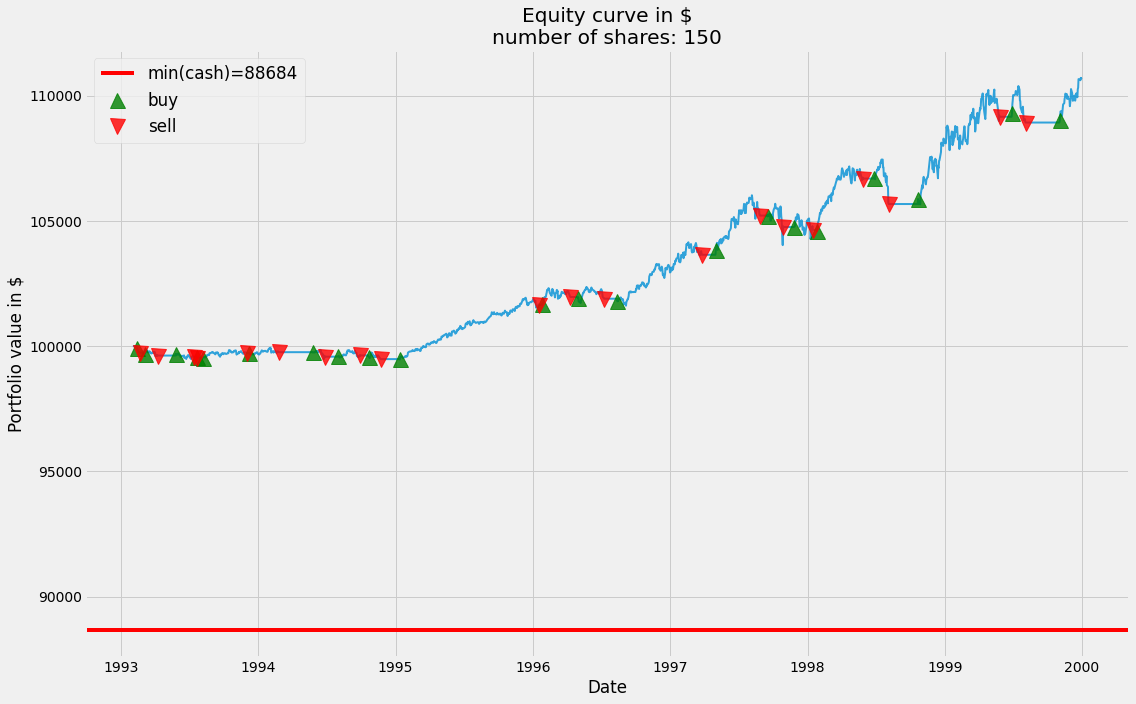

In [18]:
portfolio.plot_equity()

## In next few lines we are trying to optimize "our strategy":

We create list of 3-tuplets: (short,long,number), where:
        
        - short stands for short moving average days to look back
        - long stands for long moving average days to look back
        - number stands for number of shares to buy sell

In [28]:
l=[]
for j in range(2,20,1):
    for k in range(100,300,10):
        l=l+[(i,i*j,k) for i in range(1,21,1)]

In [29]:
tabela = pd.DataFrame(l,columns=["short","long","number of shares"])

In [30]:
tabela['result']=0.0 #result column is going to be populated by backtesting total cash on the last day of 1999 year

In [31]:
tabela.head(5)

,short,long,number of shares,result
0,1,2,100,0.0
1,2,4,100,0.0
2,3,6,100,0.0
3,4,8,100,0.0
4,5,10,100,0.0


In [32]:
tabela.shape

(7200, 4)

Because of the table size, it is going to take a while:

In [33]:
i=0
for short,long,number in l:
    mac = MovingAverageStrategy(index, data, short, long)
    signals = mac.generate_signals()
    portfolio = BacktestPortfolio(index, data, signals, initial_capital=100000.0, trade_costs=0.0025, number_of_shares = number)
    result = portfolio.backtest_portfolio()
    tabela.loc[i,'rez']=result['total'].iloc[-1]
    i=i+1

In [34]:
tabela.head(5)

,short,long,number of shares,result,rez
0,1,2,100,0.0,139882.664062
1,2,4,100,0.0,119268.839844
2,3,6,100,0.0,110798.835938
3,4,8,100,0.0,103939.804688
4,5,10,100,0.0,104813.433594


In [35]:
tabela.sort_values(by=['rez'],ascending=False)

,short,long,number of shares,result,rez
380,1,2,290,0.0,215659.725781
780,1,3,290,0.0,213152.449219
360,1,2,280,0.0,211671.459375
760,1,3,280,0.0,209250.640625
340,1,2,270,0.0,207683.192969
...,...,...,...,...,...
404,5,15,100,0.0,103047.367188
45,6,12,120,0.0,102981.662500
6,7,14,100,0.0,102824.074219
25,6,12,110,0.0,102733.190625


From the above we see obvious thing, if we buy more shares we have more money return. Also, maximum return is when short=1 and long=2, in this case we actualy look at two priceses from two days ago and from yesterday: 

    - if price from two days ago is larger then price from yesterday, today we buy 290 shares
    - else, we sell 290 shares

In [75]:
mac = MovingAverageStrategy(index, data, 1, 2)

In [76]:
signals = mac.generate_signals()

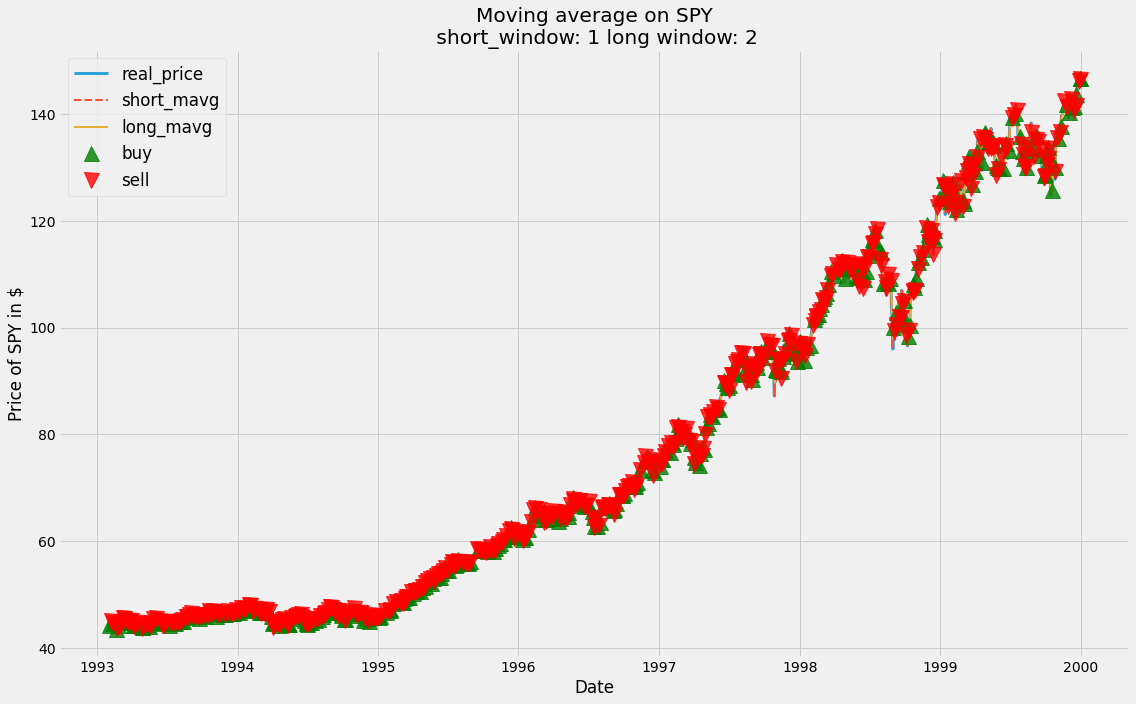

In [55]:
mac.plot_signals()

In [77]:
print("Number of buy signals: "+str(signals['positions'][signals['positions']==1].count()))
print("Number of sell signals: "+str(signals['positions'][signals['positions']==-1].count()))

Number of buy signals: 454
Number of sell signals: 453


In [78]:
portfolio = BacktestPortfolio(index, data, signals, initial_capital=100000.0, trade_costs=0.0025, number_of_shares = 290)

In [79]:
result = portfolio.backtest_portfolio()

In [80]:
result.iloc[-1]

cash              173065.975781
numberOfStocks       290.000000
holdingInStock     42593.750000
total             215659.725781
returns               -0.000178
Name: 1999-12-31 00:00:00, dtype: float64

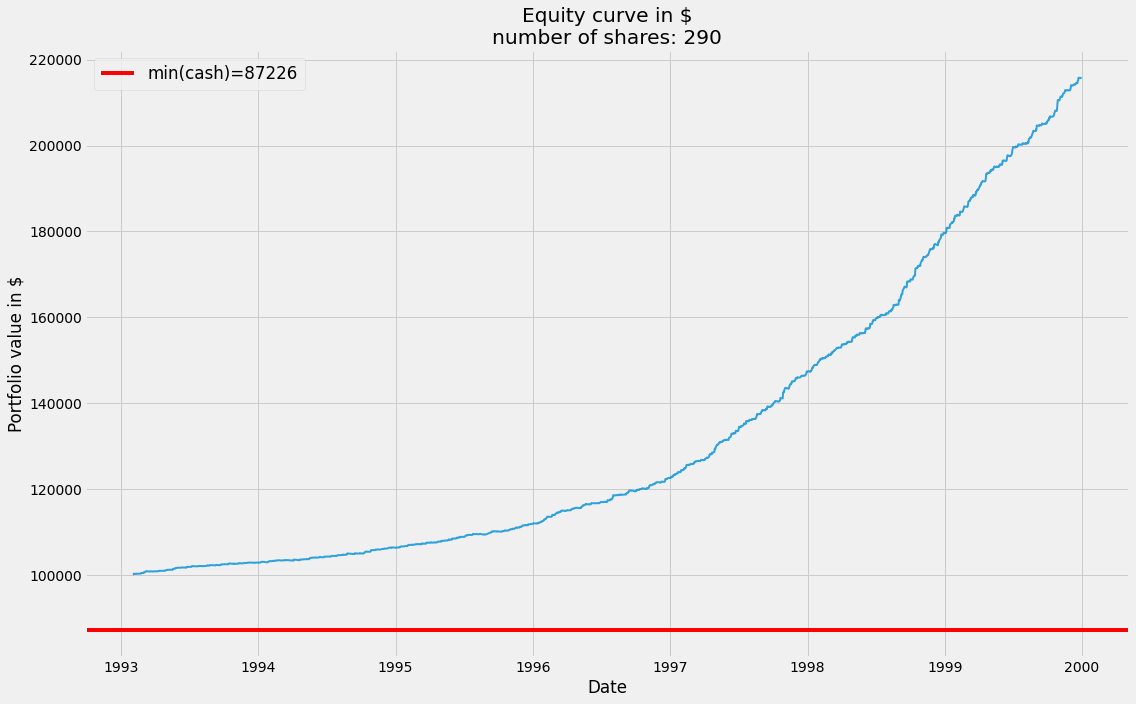

In [85]:
portfolio.plot_equity(signal=False)

Let's see other parameters in table:

In [99]:
tabela_pivot = tabela.pivot_table(['rez'],index=["short"],aggfunc=['max'])

In [118]:
tabela_pivot.sort_values(by=[tabela_pivot.columns[0]],ascending=False)

,max
,rez
short,
1,215659.725781
2,155879.635547
3,131316.624219
19,127696.812500
20,127637.532422
18,126287.865625
14,126072.427344
16,125751.626172


In [120]:
tabela[tabela['short']==19].sort_values(by=['rez'],ascending=False)

,short,long,number of shares,result,rez
7198,19,361,290,0.0,127696.812500
6798,19,342,290,0.0,127469.117188
7178,19,361,280,0.0,126741.750000
6778,19,342,280,0.0,126521.906250
7158,19,361,270,0.0,125786.687500
...,...,...,...,...,...
818,19,76,100,0.0,105966.781250
418,19,57,100,0.0,105933.753906
58,19,38,120,0.0,105868.464063
38,19,38,110,0.0,105379.425391


It's interesting to see thath forth performance was with parameters short=19, long=361, and of course number_of_shares=290.

In [108]:
mac = MovingAverageStrategy(index, data, 19, 361)

In [109]:
signals = mac.generate_signals()

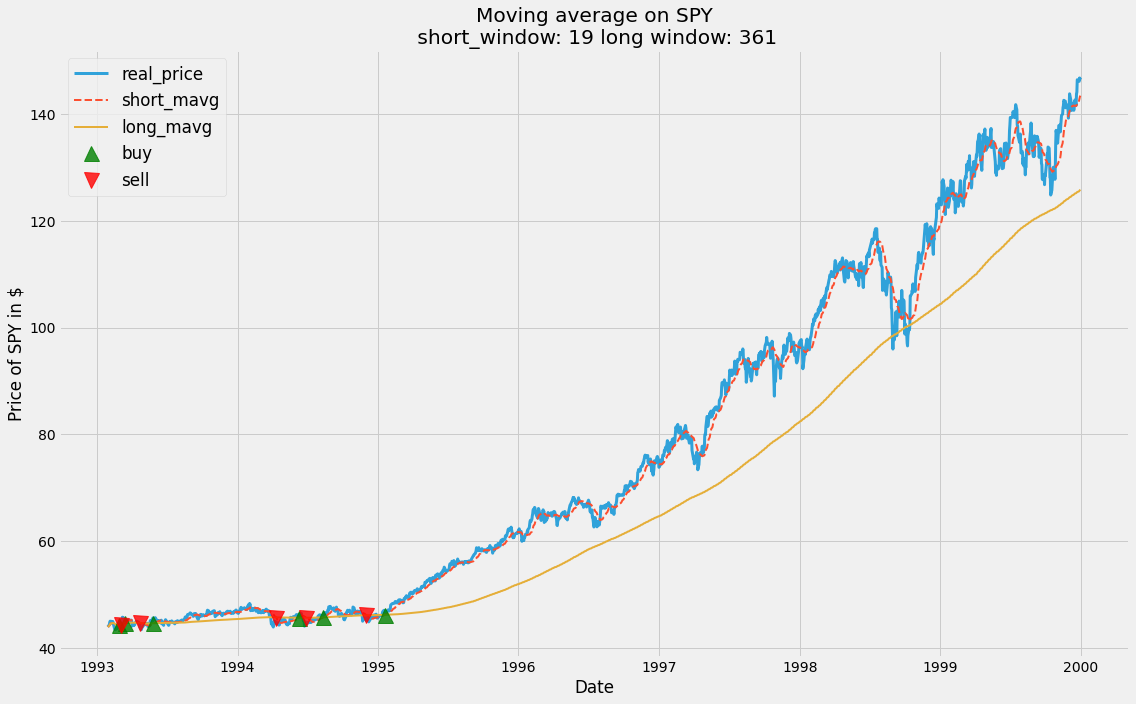

In [110]:
mac.plot_signals()

In [111]:
portfolio = BacktestPortfolio(index, data, signals, initial_capital=100000.0, trade_costs=0.0025, number_of_shares = 290)

In [112]:
result = portfolio.backtest_portfolio()

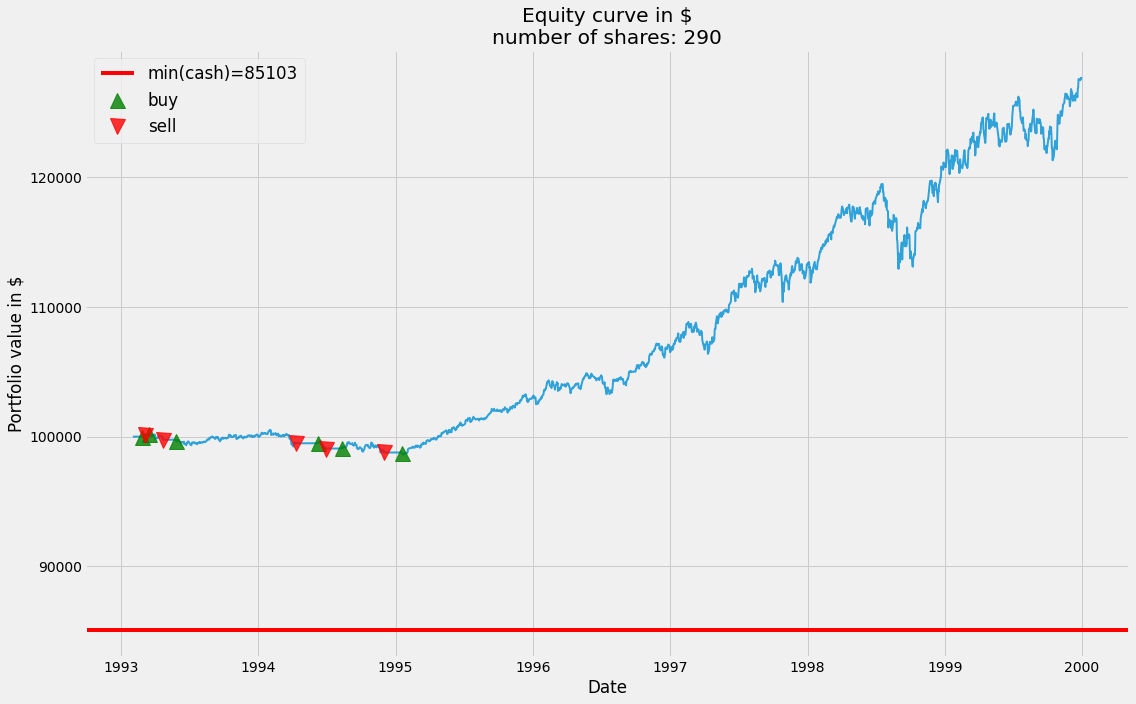

In [113]:
portfolio.plot_equity()

In [114]:
result.tail()

,cash,numberOfStocks,holdingInStock,total,returns
Date,,,,,
1999-12-27,85103.0625,290.0,42421.56250,127524.62500,-0.000462
1999-12-28,85103.0625,290.0,42394.37500,127497.43750,-0.000213
1999-12-29,85103.0625,290.0,42575.62500,127678.68750,0.001422
1999-12-30,85103.0625,290.0,42525.78125,127628.84375,-0.000390
1999-12-31,85103.0625,290.0,42593.75000,127696.81250,0.000533


## In next few lines we are trying to change "strategy" according to trend of a SPY curve:

Idea is to implement new method inside class BacktestPortfolio, to on every new buy signal buy more shares then in previus.

In [107]:
class BacktestPortfolio2(object):

    def __init__(self, index, data, signals, initial_capital=100000.0, trade_costs=0.0025, number_of_shares = 100, inc_buy=0.0):
        self.index = index        
        self.data = data
        self.signals = signals
        self.initial_capital = float(initial_capital)
        self.trade_costs = float(trade_costs)
        self.number_of_shares = number_of_shares
        self.inc_buy=float(inc_buy)
        self.positions = self.generate_positions2()
        self.portfolio = self.backtest_portfolio()
    
    def generate_positions2(self):
        positions = pd.DataFrame(index=self.signals.index).fillna(0.0)
        buy_indices = self.signals[self.signals['positions']==1].index
        for i in range(buy_indices.size):
            self.signals.loc[buy_indices[i]:,'signal'] = 1+self.inc_buy*i
        positions[self.index] = self.number_of_shares*self.signals['signal']
        return positions
                    
    def backtest_portfolio(self):
        portfolio = pd.DataFrame(index=self.signals.index).fillna(0.0)
        portfolio['cash']=self.initial_capital
        pos_diff = self.positions[self.index].diff()
        pos_diff.fillna(0.0)
        
        portfolio['numberOfStocks'] = self.positions[self.index]
        portfolio['holdingInStock'] = self.positions[self.index]*self.data['Close']
        
        portfolio['cash'] = portfolio['cash'] - (pos_diff*data['Close'].shift(1)+self.trade_costs*pos_diff.abs()*data['Close'].shift(1)).cumsum()
        
        portfolio['total'] = portfolio['cash'] + portfolio['holdingInStock']
        portfolio['returns'] = portfolio['total'].pct_change()

        return portfolio
    
    
    def plot_equity(self,signal=True):
        plt.plot(self.portfolio['total'],lw=2,alpha=0.8)
        plt.axhline(y=self.portfolio['cash'].min(),color='red',label='min(cash)='+str(round(self.portfolio['cash'].min())))
        if signal:
            plt.plot(self.portfolio.loc[signals.positions == 1.0].index, self.portfolio.total[signals.positions == 1.0],'^', markersize=15, color='g',label='buy',alpha=0.8)
            plt.plot(self.portfolio.loc[signals.positions == -1.0].index, self.portfolio.total[signals.positions == -1.0],'v', markersize=15, color='r',label='sell',alpha=0.8)
        plt.legend(fontsize='large')
        plt.xlabel('Date')
        plt.ylabel('Portfolio value in $')
        plt.title("Equity curve in $"+"\n"+"number of shares: "+str(self.number_of_shares))

In [115]:
portfolio2 = BacktestPortfolio2(index, data, signals, initial_capital=100000.0, trade_costs=0.0025, number_of_shares = 290, inc_buy = 0.1)

In [116]:
result2 = portfolio2.backtest_portfolio()

In [117]:
result2.tail()

,cash,numberOfStocks,holdingInStock,total,returns
Date,,,,,
1999-12-27,80436.933047,435.0,63632.343750,144069.276797,-0.000613
1999-12-28,80436.933047,435.0,63591.562500,144028.495547,-0.000283
1999-12-29,80436.933047,435.0,63863.437500,144300.370547,0.001888
1999-12-30,80436.933047,435.0,63788.671875,144225.604922,-0.000518
1999-12-31,80436.933047,435.0,63890.625000,144327.558047,0.000707


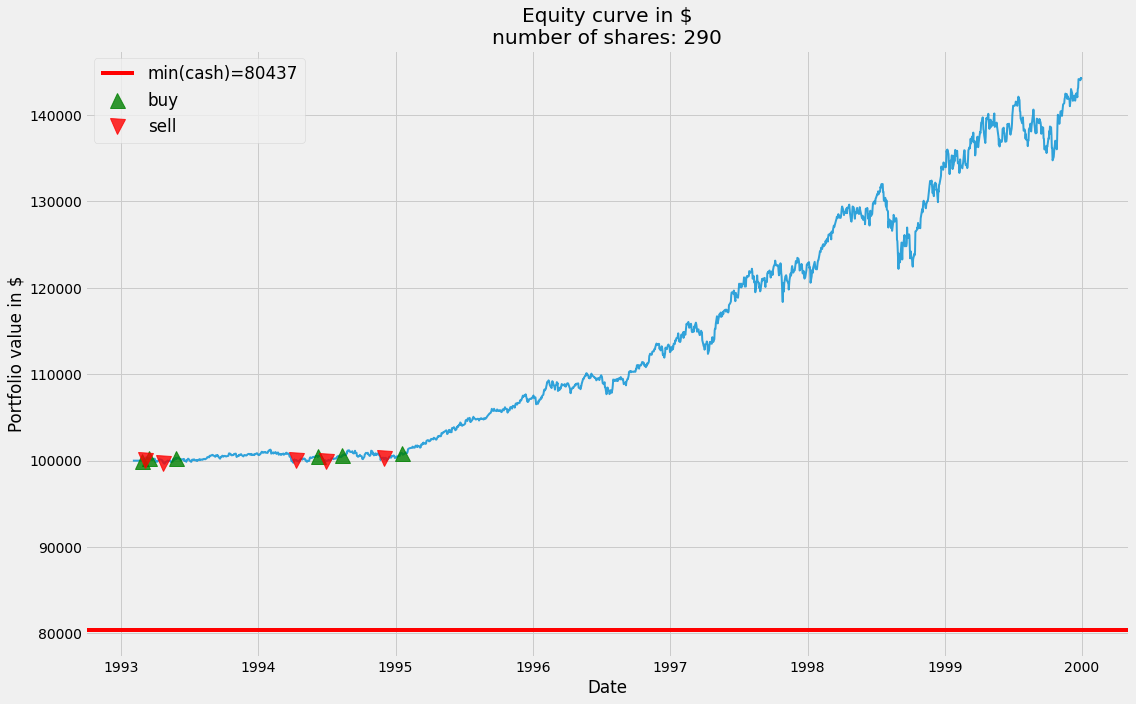

In [118]:
portfolio2.plot_equity()

This strategy benefits on above case. But on the case were we have a lot of buy sell signals this is a disaster.

In [146]:
mac = MovingAverageStrategy(index, data, 1, 2)

In [147]:
signals = mac.generate_signals()

In [148]:
portfolio2 = BacktestPortfolio2(index, data, signals, initial_capital=100000.0, trade_costs=0.0025, number_of_shares = 290, inc_buy = 0.01)

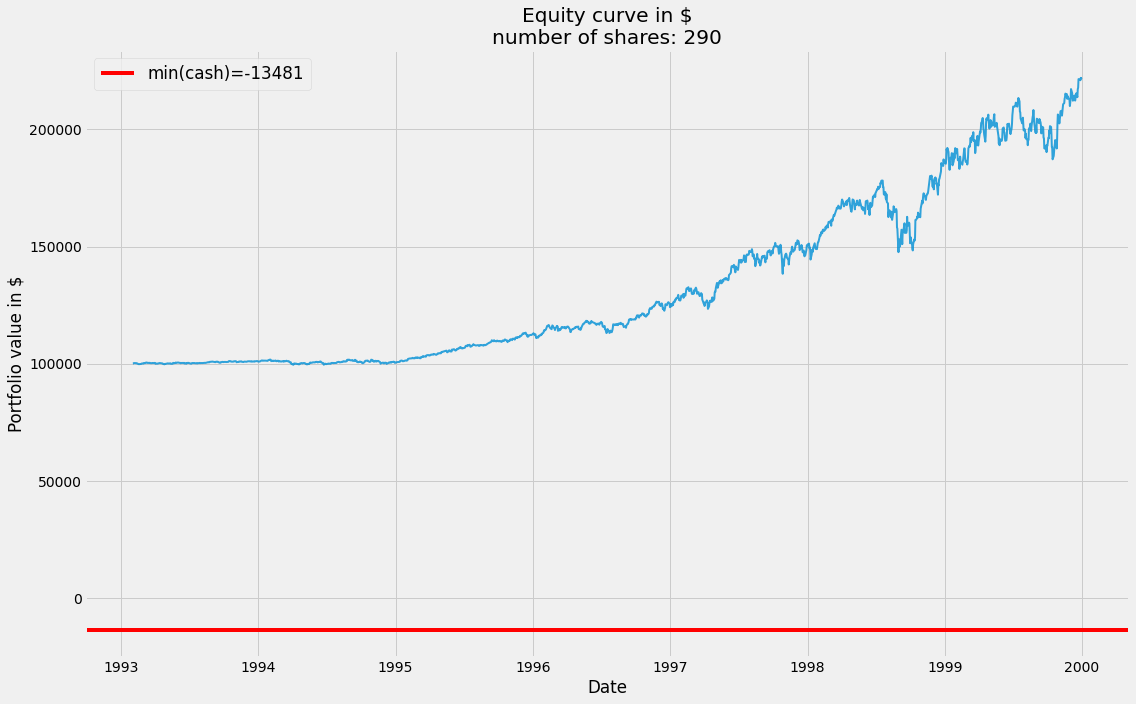

In [150]:
portfolio2.plot_equity(False)

We see that we lost all our cash.

Let's try something with 19,361 parameteres

In [151]:
mac = MovingAverageStrategy(index, data, 19, 361)

In [152]:
signals = mac.generate_signals()

In [197]:
l=[]
for i in range(20):
    l.append((i+1)*0.5)

In [198]:
tabela = pd.DataFrame(l,columns=["buy_inc"])

In [208]:
tabela["rez"]=0.0
tabela['cash']=0.0

In [211]:
for i in range(20):
    inc=l[i]
    portfolio2 = BacktestPortfolio2(index, data, signals, initial_capital=100000.0, trade_costs=0.0025, number_of_shares = 290, inc_buy=inc)
    result2 = portfolio2.backtest_portfolio()
    tabela.loc[i,'rez']=result2['total'].iloc[-1]
    tabela.loc[i,'cash']=result2['cash'].min()

In [212]:
tabela

,buy_inc,rez,cash
0,0.5,2.028301e+05,53752.012109
1,1.0,2.759584e+05,20395.860937
2,1.5,3.490866e+05,-12960.290234
3,2.0,4.222148e+05,-46316.441406
4,2.5,4.953430e+05,-79672.592578
5,3.0,5.684713e+05,-113028.743750
6,3.5,6.415995e+05,-146384.894922
7,4.0,7.147277e+05,-179741.046094
8,4.5,7.878559e+05,-213097.197266
9,5.0,8.609842e+05,-246453.348438


We see that if increment is 1.5 our cash goes to minus

In [213]:
l=[0.9,1,1.1,1.2,1.3,1.4]

In [215]:
tabela = pd.DataFrame(l,columns=["buy_inc"])
tabela["rez"]=0.0
tabela['cash']=0.0

In [221]:
for i in range(len(l)):
    inc=l[i]
    portfolio2 = BacktestPortfolio2(index, data, signals, initial_capital=100000.0, trade_costs=0.0025, number_of_shares = 290, inc_buy=inc)
    result2 = portfolio2.backtest_portfolio()
    tabela.loc[i,'rez']=result2['total'].iloc[-1]
    tabela.loc[i,'cash']=result2['cash'].min()

In [222]:
tabela

,buy_inc,rez,cash
0,0.9,261332.716172,27067.091172
1,1.0,275958.360938,20395.860937
2,1.1,290584.005703,13724.630703
3,1.2,305209.650469,7053.400469
4,1.3,319835.295234,382.170234
5,1.4,334460.940000,-6289.060000


Best way to go is for increment around 1.1

## Test strategy

In [223]:
index = 'SPY'
data = getData(index,"1999-12-31","2018-01-01")

In [244]:
mac = MovingAverageStrategy(index,data,19,360)

In [245]:
signals = mac.generate_signals()

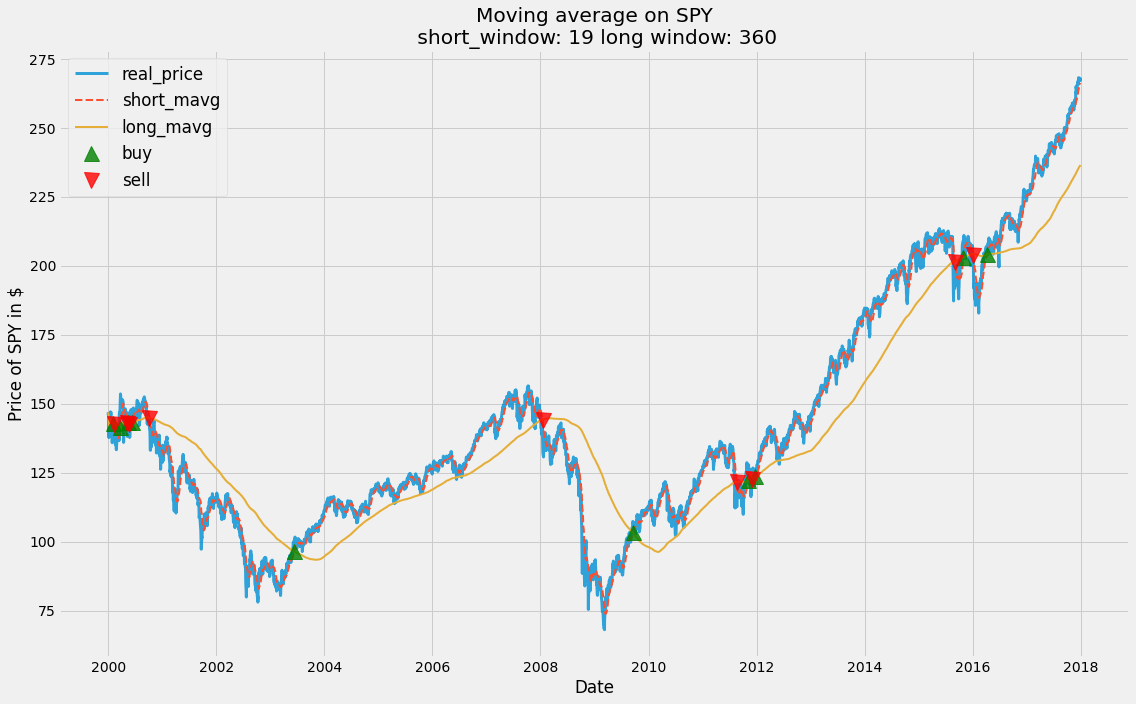

In [246]:
mac.plot_signals()

In [247]:
portfolio2 = BacktestPortfolio2(index, data, signals, initial_capital=100000.0, trade_costs=0.0025, number_of_shares = 290, inc_buy = 1.1)

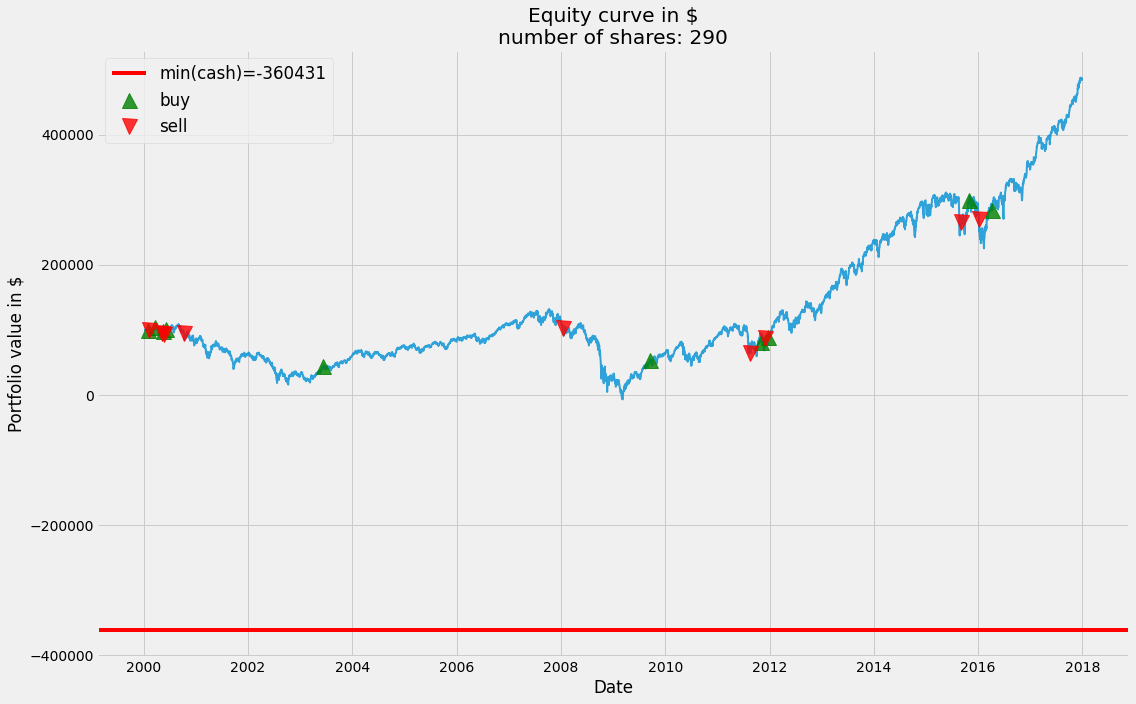

In [248]:
portfolio2.plot_equity()

We see that our strategy was bad choice

Let's see what would be with the short=1 and long=2

In [249]:
mac = MovingAverageStrategy(index,data,1,2)

In [250]:
signals = mac.generate_signals()

In [251]:
portfolio2 = BacktestPortfolio2(index, data, signals, initial_capital=100000.0, trade_costs=0.0025, number_of_shares = 290, inc_buy = 0)

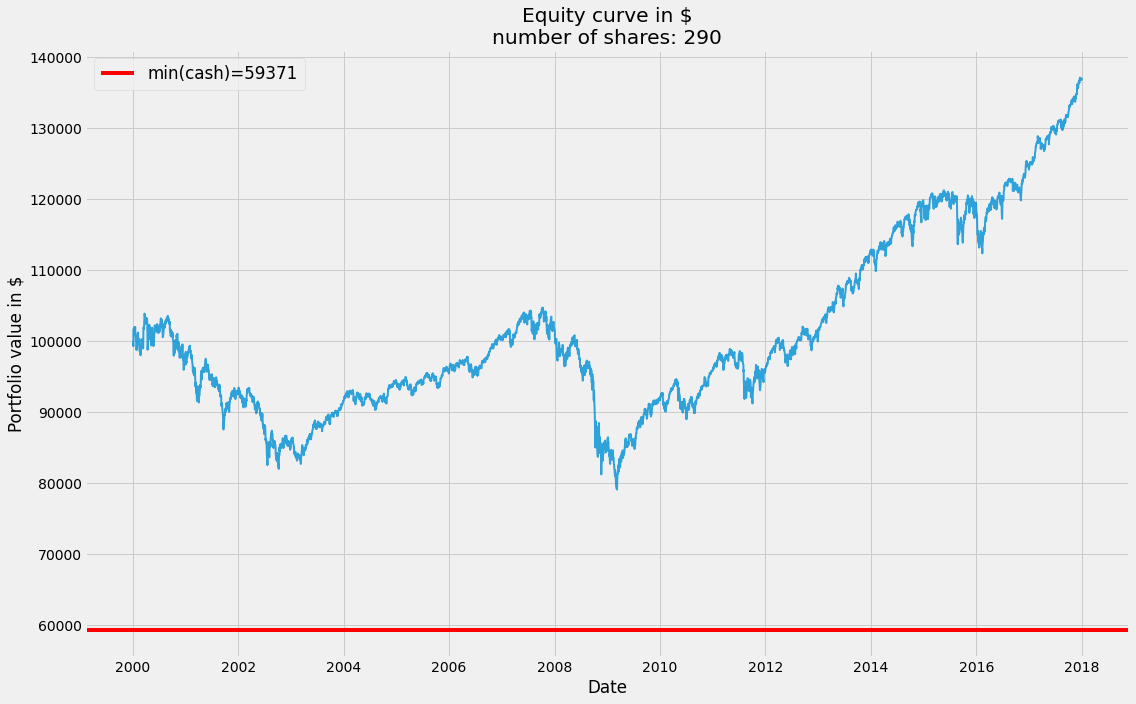

In [252]:
portfolio2.plot_equity(False)

We have result in +, but this is also bad because of long time period